## Ryan Toffel
### Senior Design Preliminary Studies

In [4]:
from __future__ import division # use so 1/2 = 0.5, etc.
%pylab inline
#%matplotlib qt
import sk_dsp_comm.sigsys as ss
import numpy as np
import scipy.signal as signal
from IPython.display import Audio, display
from IPython.display import Image, SVG

Populating the interactive namespace from numpy and matplotlib


In [5]:
pylab.rcParams['savefig.dpi'] = 100 # default 72
#pylab.rcParams['figure.figsize'] = (6.0, 4.0) # default (6,4)
#%config InlineBackend.figure_formats=['png'] # default for inline viewing
%config InlineBackend.figure_formats=['svg'] # SVG inline viewing
#%config InlineBackend.figure_formats=['pdf'] # render pdf figs for LaTeX

## Very Basic Stuff that everyone has seen before

Below is a continuous time signal at $f_{c} = 24MHz$

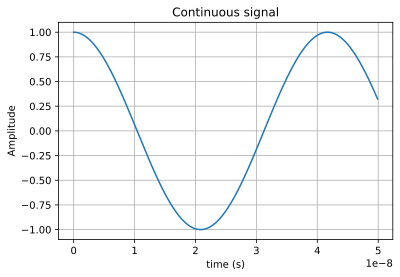

In [6]:
# Create time domain sinusoid
t = arange(0, 5e-8, 0.1e-9)
fc = 24e6 # frequency (Hz)
pc = 0 # phase (degrees)
A = 1 # Amplitude
xc = A*cos(2*pi*fc*t - pi*pc/180)
plot(t, xc);
title('Continuous signal');
xlabel('time (s)');
ylabel('Amplitude');
grid()

We can sample the above signal at $f_{s} = 2f_{c}$

c:\users\justin\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """


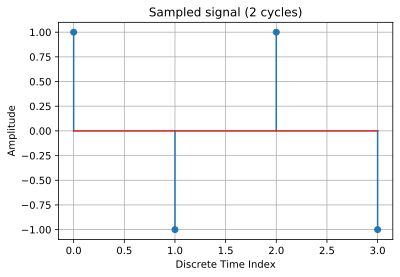

In [51]:
#sample above signal at 2*fc
fs = 2*fc #2 samples per period
n = arange(0, 4)# 2 samps per period so show 2 full periods,or 4 samples
xn = A*cos(2*pi*fc/fs*n - pi*pc/180)
stem(n, xn)
title('Sampled signal (2 cycles)');
xlabel('Discrete Time Index');
ylabel('Amplitude');
grid()

**A note on the above dsicrete plot:** Sampling frequency can be chosen by indicating the number of samples you want per period. $ T_{s} = \frac{T_{c}}{M}$, where $T_{c}$ is the continuous time period, $T_{s}$ is the sample spacing (period), and M is the number of samples per period. So choosing $f_{s}$ is equivalent to M = 2, as shown by $ \frac{1}{f_{s}} = \frac{T_{c}}{2} = 2f_{c}$. The above plot shows two samples per period, as expected. 

Having a discrete signal as the one shown above makes the concept of a phase shift a bit confusing. If you only want to shift the signal relative to a integer number of samples, e.g. move the value at n = 1 to n = 2, then your resolution is resitricted by the sample spacing/period. In the above example, if we want to implement a phase shift based on the discrete samples, we can delay by multiples of $\frac{1}{2f_{c}} = 25ns$. This is equivalent to a phase shift of 216 degrees relative to the input frequency. Intuitively, we can also just add a phase argument ($\phi$) to the discrete cosine signal as shown below.  

$x[n]= Acos(\omega_{s}n - \phi)$    

However, we have to consider that because this is a frequency dependend phase shift, we have to scale $\phi$ accordingly during the Digital to Analog conversion. 

Another common approach is to use the Fast Fourier Transform (FFT) and the Inverse Fast Fourier Transform (IFFT). The FFT algorithm computes the Dicrete Fourier Transform (DFT); thus, a phase shift is implemented by complex multiplication on the DFT. The process is shown by the block diagram and code below. 

<img src="fft_phase_shift.png">

In [58]:
# Direct phase shift via FFT
X_f = np.fft.fft(xc)
X_fp = X_f*exp(1j*pi)#shift by 180 degrees #xff
xc_shift = np.fft.ifft(X_fp) #xffp

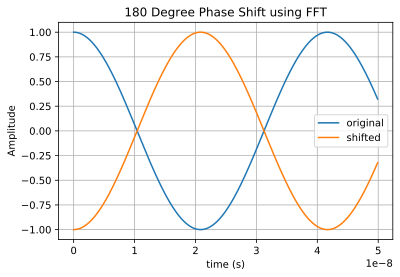

In [59]:
plot(t, xc, label= 'original');
plot(t, xc_shift, label= 'shifted');
title("180 Degree Phase Shift using FFT")
xlabel('time (s)');
ylabel('Amplitude');
grid()
legend();

## better stuff/simulations to come in near future

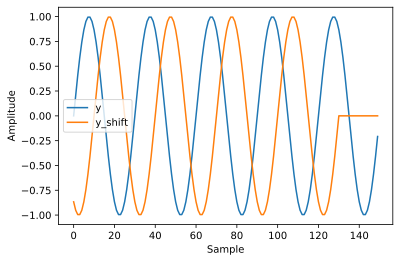

In [66]:
import matplotlib.pyplot as plt
import numpy as np

def nextpow2(i):
    n = 1
    while n < i: 
        n *= 2
        
    return n

def shift_signal_in_frequency_domain(datin, shift):
    '''
    This is function to shift a signal in frequency domain. 
    The idea is in the frequency domain, 
    we just multiply the signal with the phase shift. 
    '''
    Nin = len(datin) 
    
    # get the next power 2 number for fft
    N = nextpow2(Nin +np.max(np.abs(shift)))
    
    # do the fft
    fdatin = np.fft.fft(datin, N)
    
    # get the phase shift for the signal, shift here is D in the above explaination
    ik = np.array([2j*np.pi*k for k in range(0, N)]) / N 
    fshift = np.exp(-ik*shift)
        
    # multiple the signal with the shift and transform it back to time domain
    datout = np.real(np.fft.ifft(fshift * fdatin))
    
    # only get the data have the same length as the input signal
    datout = datout[0:Nin]
    
    return datout

Fs = 150.0;  # sampling rate
Ts = 1.0/Fs; # sampling interval
t = np.arange(0,1,Ts) # time vector

ff = 5;   # frequency of the signal

# let's generate a sine signal
y = np.sin(2*np.pi*ff*t)

# shift the signal in the frequency domain by 20 samples
y_shift = shift_signal_in_frequency_domain(y, -20)

plt.plot(y, label = 'y')
plt.plot(y_shift, label = 'y_shift')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

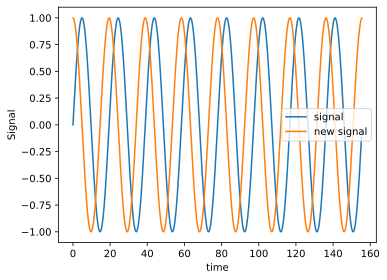

In [70]:
import matplotlib.pyplot as plt
import numpy as np
import cmath

# Generate a model signal
t0 = 0 #1250.0
dt = 0.152
freq = (1./dt)/128

t = np.linspace( t0, t0+1024*dt, 1024, endpoint=False )
signal = np.sin( t*(2*np.pi)*freq )

## Fourier transform of real valued signal
signalFFT = np.fft.rfft(signal)

## Get Power Spectral Density
signalPSD = np.abs(signalFFT) ** 2
signalPSD /= len(signalFFT)**2

## Get Phase
signalPhase = np.angle(signalFFT)

## Phase Shift the signal +90 degrees
newSignalFFT = signalFFT * cmath.rect( 1., np.pi/2 )

## Reverse Fourier transform
newSignal = np.fft.irfft(newSignalFFT)

## Uncomment this line to restore the original baseline
# newSignal += signalFFT[0].real/len(signal)


# And now, the graphics -------------------

## Get frequencies corresponding to signal 
fftFreq = np.fft.rfftfreq(len(signal), dt)

plt.figure( figsize=(10, 4) )

ax1 = plt.subplot( 1, 2, 1 )
ax1.plot( t, signal, label='signal')
ax1.plot( t, newSignal, label='new signal')
ax1.set_ylabel( 'Signal' )
ax1.set_xlabel( 'time' )
ax1.legend()

'''
ax2 = plt.subplot( 1, 2, 2 )
ax2.plot( fftFreq, signalPSD )
ax2.set_ylabel( 'Power' )
ax2.set_xlabel( 'frequency' )

ax2b = ax2.twinx()
ax2b.plot( fftFreq, signalPhase, alpha=0.25, color='r' )
ax2b.set_ylabel( 'Phase', color='r' )
'''


plt.tight_layout()

plt.show()